# Projet : Détection De Faux Billets.
# Tiziri OULD HADDA 
# M1 INFORMATIQUE

## Bibliothèque utilisées dans le projet : 

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# racine carré : sqrt
import math
#Pour les décomposition PCA et NMF
from sklearn.decomposition import PCA, NMF
# Noyau RBF
from sklearn.gaussian_process.kernels import RBF
# librairie pymf3 (contient semiNMF, kernelNMF, convexNMF...etc)
import pymf3
# matrice de contingences (metrics.cluster.contingency_matrix)
from sklearn import metrics

## Question 1:
### Question 1a:
### Présentation des données sous forme matricielle:
Les informations sur les billets sont données sous forme matricielle (dans __data__) après chargement du fichier.

Les ligne représentes les billets et les colonnes les quatres attributs de chaque billet ainsi que leurs labels associés (5ieme colonne : vrai ou faux billet).

In [2]:
data = np.loadtxt('bank_auth.txt', delimiter=',')
bank_data   = data[:,0:4]
bank_labels = data[:,4]

### Question 1b:
La syntaxe : _data[:,4] == i_

* retourne un vecteur de booléen qui est à true lorsque le label du billet est égale à i.

Dans python, on peut utiliser un vecteur de booléens pour filter les billets (en selectionner uniquement ceux dont la valeur dans ce dernier est _true_)

In [3]:
A_vrais = data[data[:,4] == 1]
A_faux  = data[data[:,4] == 0]

### Question 1c:

Une fois **A_vrais** et **A_faux** sont construits. On peux maintenant construire **bank_train** et **bank_test**.

J'ai rajouter ici **bank_train_labels** et **bank_test_labels**, pour des besoins comme l'affichage et le calcule des indices externes ou ils sont utilisés comme les labels de base (**y_true**)

In [4]:
bank_train = np.concatenate((A_vrais[:500,0:4],A_faux[:600,0:4]))
bank_train_labels = np.concatenate((np.ones(500),np.zeros(600)))

bank_test = np.concatenate((A_vrais[500:,0:4],A_faux[600:,0:4]))
bank_test_labels = np.concatenate((np.ones(A_vrais[500:,0:4].shape[0]),np.zeros(A_faux[600:,0:4].shape[0])))

### Question 1d:
* Pour généraliser la visualisation de nos données et éviter la répitition dans le code, j'ai créé la fonction **_plotcluster_** qui prend en en argument la matrice de données (exemple: bank_test, bank_train) et les labels associées a chaque billets de cette matrice et l'argument titre pour associer un titre a chaque visualisation.
* Dans plt.scatter: labels[:]==1 (respectivement labels[:]==0) pour dire que  toutes les lignes dont la 5eme colonne vaut 1 (respectivement 0) seront selectionner pour plt.scatter.
* la pca est utilisé pour réduire la dimension de nos donnée de 4 à 2 ainsi on peut utiliser la fonction scatter pour voir la position de nos point.
* sur la deuxiéme composante de la PCA, un signe négatif à été rajouter pour avoir une visualisation identique à cette dans le sujet du projet.

In [5]:
def plotcluster(X,labels,titre):
    pca = PCA(n_components = 2)
    pca.fit(X) # calculer les nouveau axes
    bt_pca = pca.transform(X) # projeter sur les nouveaux axes
    plt.xlabel('nouvel axe 1')
    plt.ylabel('nouvel axe 2')
    plt.title(titre)
    plt.scatter(bt_pca[labels[:]==1,0], -bt_pca[labels[:]==1,1], marker = '.', c = 'blue')
    plt.scatter(bt_pca[labels[:]==0,0], -bt_pca[labels[:]==0,1], marker = '+', c = 'red')
    plt.show()

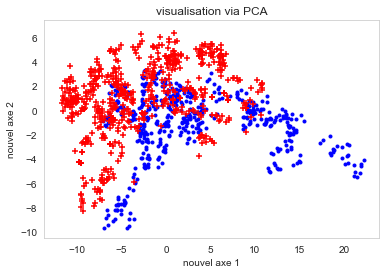

In [6]:
plotcluster(bank_train, bank_train_labels, 'visualisation via PCA')

## Question 2: application de la semi_nmf sur bank_train

**_Remarque_**: j'ai transposé **bank_train** pour adapter la forme de nos données au besoin de la nmf où dans ce cas:

* les colonnes representent les billets
* les lignes les attributs de chaque billets.

**num_bases vaut ici 2** (car ici on cherche juste deux clusters).

In [7]:
x = bank_train.T
snmf = pymf3.semiNMF(x, num_bases = 2)
snmf.factorize()
# la matrice de prototype
W_train = snmf.W
#matrice de partition 
H_train = snmf.H

### Question 2a: La fonction **_showclusters_**

**remarque:**
* Tel que vu dans le cours, il est possible de réecrire la fonction cout de la décomposition NMF et de faire une analogie a celle de l'algorithme kmeans pour trouver les correspondances. Ceci démontre la capacité de NMF à faire du clustering.

### showclusters:
Dans cette question, on utilisera La fonction showclusters pour trouvé le cluster dominant pour chaque billet.

Cette fonction fait une copie (en mémoire) de la matrice H et met pour chaque billets de cette nouvelle matrice à 1 uniquement l'indice du cluster ayant la valeur maximal sinon il est égale à 0.

### get_labels:
à partir de la matrice de partition qui résulte de la fonction _showclusters_ on peut utiliser la fonction **getlabels** pour retourné pour chaque billets l'indice du cluster associés (via la fonction argmax).

Dans notre cas (2 classe uniquement) on peut prendre uniquement la premiere ou la deuxieme colonne de la matrice de partition(car elle donne toujours deux clusters differents)

In [8]:
def showclusters(H):
    partitions = np.copy(H)
    c = H.shape
    a = c[0]
    b = c[1]
    for i in range (b):
        m = max(partitions[:,i])
        for j in range (a):
            if partitions[j,i] == m :
                partitions[j,i] = 1 
            else: 
                partitions[j,i] = 0
    return partitions

def get_labels(X):
    y = X.T
    shape_X = y.shape
    y_labels = np.zeros((shape_X[0]), 1)
    for i in range (shape_X[0]):
            y_labels[i] = np.argmax(y[i,:])
    return y_labels 

In [9]:
partition_train = showclusters(H_train)

### Remarques importantes:
* Dans l'implémentation des indices suivants il est importants ici qu'on puisse distinguer entre deux notions : **les labels de base** et les **labels résultants** de notre algorithme du clustering (nmf), qu'on appelera respéctivement **clusters** et **classes**.

* dans un algorithme de clustering, si on note par que 0 la classe de base réprésentant les faux billets et 1 celle qui représente les vrai billets. les valeurs (indices) des clustering qu'on va trouver par NMF ne seront pas forcéments représenté par les même valeurs.

* En effet, cela dépend surtout de la phase d'initialisation des matrice W et H (ou F, H tel que vu dans le cours) qui est dans notre cas faites d'une manière aléatoire. Donc d'une execution à une autre la classe 0 peut être représenté par le cluster 0 comme par le cluster 1, et même chose pour la classe 1. 

* De plus la solution n'étant pas unique nous pouvant atterire sur une solution autre que celle attendu, dans ce cas on parle d'un minimum local.
### Indice de qualité du clustering:
Il existe deux type d'indices pour mesurer la qualité d'un algorithme de clustering:
* indices externes : qui utilisent les classes de base et celle trouvées par l'algorithme de clustering pour calculer une qualité particuliers.
* indices internes : qui utilisent uniquement les clusters trouvées par l'algorithme et les données de base (sans labels).

### Définition de la fonction purity:
La fonction de purity, indique combien l'algorithme de clustering est précis. Pour calculer la pureté je suis parti de la matrice de contingence.

On effet la matrice de contingence résume la répartition des classe de base dans les clusters trouvés (et vis versa). chaque ligne représente une classe donnée et les colonnes représentent les clusters.

Si on note $M$ la matrice de contingence, $M_{ij}$ représente combien (répartition) d'éléments initialement dans la classe $i$ sont regroupé par l'algorithme dans le cluster $j$.

On fait la corresponsance entre Classe-Cluster on choisisant pour chaque Classe, le cluster ayant le nombre maximale de points.

Donc la purity de notre clustering la somme des maximum pour chaque classe diviser par le nombre total de billets (sum de toutes les $M_{ij}$)

In [10]:
def purity(y_true, y_pred):
    matrix_contingency = metrics.cluster.contingency_matrix(y_true,y_pred)
    max_clusters = np.amax(matrix_contingency, axis=0)
    num_elements = np.sum(matrix_contingency)
    return np.sum(max_clusters)/num_elements

In [11]:
partition_train

array([[0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 1., 0.]])

### calcul de la pureté pour la matrice de partition calculé precedemment

In [12]:
y_true = bank_train_labels
y_pred = partition_train[1,:].T
puretee = purity(y_true, y_pred) 
print('la vvaleur de la pureté est:', puretee)

la vvaleur de la pureté est: 0.6345454545454545


### Question  2b:

**Remarque**

* On remarque que W_train n'est pas carrée, ainsi pour qu'on puisse calculer son inverse, on utilise la fonction __pinv__

In [13]:
H_test = np.dot(np.linalg.pinv(W_train), bank_test.T) 
partition_test = showclusters(H_test)

### Question 2c:
### la fonction d'entropy
Le principe est le suivant: 

On peut définir l'entropy comme une sorte d'indice d'incertitude d'un cluster. exemple :

 * Si pour un cluster 0 ayant 10 billets, et que sur ces 10 billets 5 sont reparties par l'algorithme dans une classe 0 et 5 dans un classe 1. 
 * utiliser le max  pour choisir quel classe qui représente le cluster 0 ne serait différencier cela car les deux clusters sont équiprobable, p = 0.5 (et on ne doit pas choisir un au hasard ou par défaut) => **mavais choix**.
 * Dans ce cas il faut utiliser un autre indice plus éfficace (ou plus parlant), qui est l'entropie. 
 * Dans l'exemple si dessus, **il y a confusion (on est incertain car la probabilité pour chaque classe est p=5/10=0.5) => entropy maximal**.
 * Le but ici est de d'avoir une entropy minimal. Exemple:
     * Dans le cluster 0 précédent qui comporte 10 billets, si 10 sont repartie dans une classe 1 et 0 dans la classe 0, dans ce cas **on est certain** que la cluster 0 représente la classe 1 $p = 10/10$ (on est certain aussi qu'il ne représente pas la classe 0 $p = 0/10$). => **donc plus de confusion => entropy minimal**
     
* L'entropie globale: est la somme des entropies de ces clusters multiplié par le rapport Nombre de points dans ce clusters/Nombre de points total.

     
### Calcule de l'entropie

Pour chaque cluster on calcule :

$H(i) = - \sum_{j \in Classes} p_{ij} log_b(p_{ij}) $

L'entropie totale:

$H =  \sum_{j \in Clusters} H(i) \frac{N_i}{N}  $

tel que:

* $H$ : entropie totale
* $H(i)$ : entropie d'un cluster i
  (voir https://fr.wikipedia.org/wiki/Entropie_de_Shannon)
* $p_{ij} = \frac{N_{ij}}{N}$ : probabilité pour qu'un point dans la classe i soit rerouper dans le cluster j
* $N_{ij}$ : Nombre de points dans cluster i classé dans la classe j
* $N_i$ : Nombre de points dans cluster i
* $N$ : Nombre de points total
* $Classes$ : l'ensembles des classes
* $Clusters$ : l'ensembles des Clusters
* $log_b$ : logarithme binaire

Comme dans purity on utilise la **matrice de contingence** pour calculer la repartition de nos classe de base ou clusters (et vis versa).



In [14]:
def entropy(y_true,y_pred):
    matrix_contingency = metrics.cluster.contingency_matrix(y_true,y_pred)
    N = np.sum(matrix_contingency)
    num_clusters = matrix_contingency.shape[0]
    N_i = np.zeros(num_clusters)
    probability_matrix = matrix_contingency.copy().astype('float')
    H = 0
    for i in range (num_clusters):
        N_i[i] = np.sum(matrix_contingency[:,i])
        for j in range (num_clusters):
            probability_matrix[j,i] = probability_matrix[j,i] / N_i[i]
        H += sp.stats.entropy(probability_matrix[:,i]) * N_i[i] / N
    return H

In [15]:
print('purity de Htest est :', purity(bank_test_labels,partition_test[1,:]))
print('entropy de Htest est :', entropy(bank_test_labels,partition_test[1,:]))

purity de Htest est : 0.6102941176470589
entropy de Htest est : 0.6578850919057102


### Question 2d: 

Le cas le plus favorable pour appliquer du clustering sur des données et en effet le cas ou les classes sont compactes et la distance entre les classes sont importantes.

Pour définir la compacité de nos classe on peux se utiliser : 
* La distance maximale entre le centre de la classe $\mu$ et un point $x$ de cette classe  
* La distance maximale entre deux points $x$ de cette classe
* ..etc

Pour la distance entre les classe on peut choisir :
* la distance minimale entre les centres de ces classes.
* la distance minimale entre deux points de classes différentes (trop couteux en calcule)
* ..etc

Il existe dans la littérature, certain indices déjà prédifinie qui utilise ces notions comme ceux qu'on utilisera dans ce projet:


### L'implementation des l'indices internes DB, Dunn, CH
$ S_{DB} ={\frac {1}{K}} \sum_{k=1}^{K} \max_{k'\neq k}({\frac{{\bar{\delta}}_{k}+{\bar{\delta}}_{k'}}{d(\mu_{k},\mu_{k'})}})$



$S_{D}={\frac {\displaystyle \min_{1\leqslant k<k'\leqslant K}d(\mu_{k},\mu_{k'})}{\displaystyle \max_{1\leqslant k\leqslant K}\Delta_{k}}}$

$S_{CH}={\frac{\displaystyle (N-K)B}{\displaystyle (K-1)\sum_{k=1}^{K}W_{k}}}$
* $N$ _nombre de billets_
* $K$ _nombre de classes_
* $\mu _{k}={\frac{1}{\vert I_{k}\vert }}\sum _{i\in I_{k}}x^{i}$ : centre de la classe k
* $\mu ={\frac {1}{N}}\sum _{i=1}^{N}x^{i}$ : centre de tout les points (toutes nos données)
* $\bar {\delta }_{k}={\frac {1}{\vert I_{k}\vert }}\sum _{i\in I_{k}}d(x^{i},\mu _{k})$ : distances moyenne (somme des distance/ le nombre de distance) entre le centre de la classe et les points de la meme classe.
* $\Delta _{k}=\max _{i,i'\in I_{k}}d(x^{i},x^{i'})$ : distance maximale entre deux points de la même classe
* $W_{k}={\frac {1}{\vert I_{k}\vert }}\sum _{i\in I_{k}}\Vert x^{i}-\mu _{k}\Vert$
* $B=\sum _{k=1}^{K}\vert I_{k}\vert \Vert \mu _{k}-\mu \Vert$

## Implémentation :
Pour simplifier l'implémentation de ces indices, on limite ces équations à deux clusters.<br>

In [16]:
def distance(x1, x2):
    return math.sqrt(np.sum((x1 - x2) ** 2))

def davies_bouldin(X, Y_labels):
    cluster1 = X[Y_labels[:]==1]
    cluster0 = X[Y_labels[:]==0]
    mean_cluster0 = cluster0.mean(axis=0)
    mean_cluster1 = cluster1.mean(axis=0)
    delta0 = 0
    nbr_elem_0 = cluster0.shape[0]
    for i in range (nbr_elem_0):
        delta0 += distance(cluster0[i], mean_cluster0)
    delta0 = delta0 / nbr_elem_0
    
    delta1 = 0
    nbr_elem_1 = cluster1.shape[0]
    for i in range (nbr_elem_1):
        delta1 += distance(cluster1[i], mean_cluster1)
    delta1 = delta1 / nbr_elem_1
    
    return  1/2 * (delta1 + delta0) / distance(mean_cluster0, mean_cluster1)

def dunn(X, Y_labels):
    cluster1 = X[Y_labels[:]==1]
    cluster0 = X[Y_labels[:]==0]
    mean_cluster0 = cluster0.mean(axis=0)
    mean_cluster1 = cluster1.mean(axis=0)
    delta0 = 0
    nbr_elem_0 = cluster0.shape[0]
    
    for i in range (nbr_elem_0):
        for j in range (i+1 , nbr_elem_0):
            d  = distance(cluster0[i], cluster0[j])
            if(d > delta0):
                delta0 = d
                
    delta1 = 0
    nbr_elem_1 = cluster1.shape[0]
    for i in range (nbr_elem_1):
        for j in range (i+1 , nbr_elem_1):
            d  = distance(cluster1[i], cluster1[j])
            if(d > delta1):
                delta1= d
    
    return  distance(mean_cluster0, mean_cluster1) / max(delta0, delta1)

def calinski_harabasz(X, Y_labels):
    cluster1 = X[Y_labels[:]==1]
    cluster0 = X[Y_labels[:]==0]
    mean_cluster0 = cluster0.mean(axis=0)
    mean_cluster1 = cluster1.mean(axis=0)
    mean_x = X.mean(axis=0)
    N = X.shape[0]
    K = 2

    W0 = 0
    nbr_elem_0 = cluster0.shape[0]
    for i in range (nbr_elem_0):
        W0 += distance(cluster0[i], mean_cluster0)
    W0 = W0 / (nbr_elem_0 - 1)
    
    W1 = 0
    nbr_elem_1 = cluster1.shape[0]
    for i in range (nbr_elem_1):
        W1 += distance(cluster1[i], mean_cluster1)
    W1 = W1 / (nbr_elem_1 -1)
    
    #calcul de B
    B = nbr_elem_0 * (distance(mean_cluster0, mean_x)) + nbr_elem_1 * (distance(mean_cluster1, mean_x))
    
    return  (N - K) * B / (K - 1) * (W0 + W1)

In [17]:
purity_SNMF  = purity (bank_test_labels,partition_test[1,:])
entropy_SNMF = entropy(bank_test_labels,partition_test[1,:])

DB_SNMF   =  davies_bouldin(bank_test,partition_test[1,:])
Dunn_SNMF =  dunn(bank_test,partition_test[1,:])
CH_SNMF   =  calinski_harabasz(bank_test,partition_test[1,:])


purity_SNMF, entropy_SNMF, DB_SNMF, Dunn_SNMF, CH_SNMF

(0.6102941176470589,
 0.6578850919057102,
 0.4623408334156941,
 0.4785017412023996,
 4082776.314584705)

### Question 2e: 

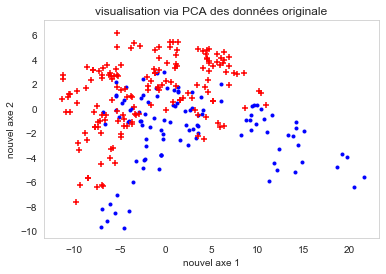

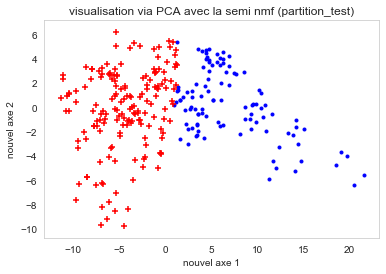

In [18]:
plotcluster(bank_test, bank_test_labels, 'visualisation via PCA des données originale')
plotcluster(bank_test, partition_test[0,:], 'visualisation via PCA avec la semi nmf (partition_test)')

## Question 3
## Application de la nfm classique sur nos données:

* Les valeurs de nos données sont négative et ne premettent pas donc d'utiliser la nfm classique. Nous devons appliquer dans ce cas une transformation pour qu'elle devienne positive.

Pour cela, on peux utiliser une des quatre propostitions suivantes:

* Utilisation de la valeur absolue.
* Calcul du carré nos données.
* le décalage de toutes les valeurs par le min sur tout les données bank_data (bank_data.min())
* normalisation qui consiste à faire un decallage plus un changement d'echelle (division par la valeur max après décallage).

Les deux premieres méthodes présentent un inconvénient important car cela revient à dire qu'une valeur positive et son négative (2 et -2 par exemple) représenterai la même chose => cela est faux et on perdera le sens de nos données.

Les deux solutions candidates sont donc les deux dernieres propositions. J'ai décider dans ce cas d'appliquer le décallge en ajoutant une valeur positive à nos données (-data.min()):


In [19]:
X_positif = bank_train - bank_data.min()
nmf = NMF(n_components = 2, init = 'random', solver = 'mu', max_iter = 500)
nmf.fit(X_positif.T)

NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0, max_iter=500,
    n_components=2, random_state=None, shuffle=False, solver='mu', tol=0.0001,
    verbose=0)

* matrice prototype est W 
* matrice de partition est H

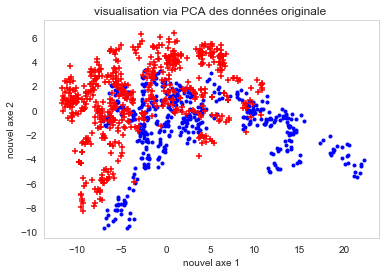

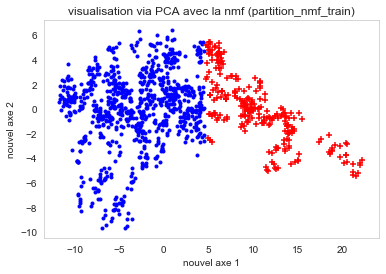

In [20]:
W = nmf.transform(X_positif.T)

H = nmf.components_

H.shape

partition_nmf_train = showclusters(H)

plotcluster(X_positif, bank_train_labels, 'visualisation via PCA des données originale ')
plotcluster(X_positif, partition_nmf_train[0,:], 'visualisation via PCA avec la nmf (partition_nmf_train)')

**Remarque : le fait de faire un décalage ne change pas le resultat de la visualisation quant a la position des billets apres pca**
### Question 3a:

In [21]:
print('purity de la matrice de partition de X_positif est :', purity(bank_train_labels,partition_nmf_train[1,:]))

purity de la matrice de partition de X_positif est : 0.6154545454545455


### Question 3b:

In [22]:
Xtest_positif = bank_test - bank_data.min()

H_test = np.dot(np.linalg.pinv(W), Xtest_positif.T) 
partition_nmf_test = showclusters(H_test)

### Question 3c:
* la pureté 
* l'entropie de H_test pour Xtest_positif

In [23]:
print('purity de Htest est :', purity(bank_test_labels,partition_nmf_test[1,:]))
print('entropy de Htest est :', entropy(bank_test_labels,partition_nmf_test[1,:]))

purity de Htest est : 0.625
entropy de Htest est : 0.6599951944467781


### Question 3d:

In [24]:
purity_NMF  = purity (bank_test_labels,partition_nmf_test[1,:])
entropy_NMF = entropy(bank_test_labels,partition_nmf_test[1,:])

DB_NMF   = davies_bouldin(bank_test,partition_nmf_test[1,:])
Dunn_NMF = dunn(bank_test,partition_nmf_test[1,:])
CH_NMF   = calinski_harabasz(bank_test,partition_nmf_test[1,:])

purity_NMF, entropy_NMF, DB_NMF, Dunn_NMF, CH_NMF

(0.625,
 0.6599951944467781,
 0.41084097807864906,
 0.6599122247844939,
 3276535.0737899356)

### Question 3e:

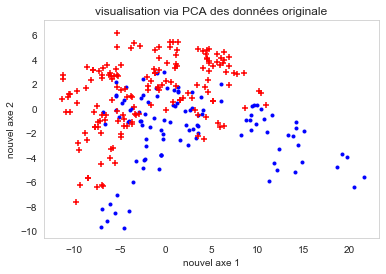

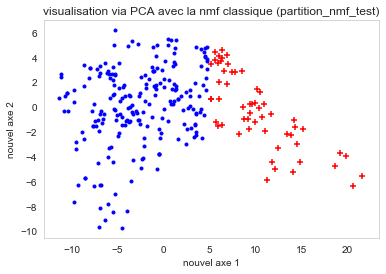

In [25]:
plotcluster(Xtest_positif, bank_test_labels, 'visualisation via PCA des données originale')
plotcluster(Xtest_positif, partition_nmf_test[0,:], 'visualisation via PCA avec la nmf classique (partition_nmf_test)')

## Question 4: Symetrique NMF

On utilisera ici la matrice de Gram comme entrée au lieu de bank_test ou bank data pour ce la nous utiliserons la notion de fonction noyau:

__une fonction noyau (kernel)__ $k$ est définie comme suit : <br> 
$k(x_i, x_j) = <\Phi(x_i),\Phi(x_j)>$ <br>

* ou $x_i$ et $x_j$ représentent des données définient avec $n$ attributs (dimensions)
* $<x_i,x_j>$ est le produit scalaire entre deux vecteurs $x_i$ et $x_j$
* $\Phi(x_i)$ est la transformation par passage à un autre espace de dimension supérieur 
* (voir https://fr.wikipedia.org/wiki/Astuce_du_noyau#/media/Fichier:PCAKernel.png)

Le produit scalaire $<\Phi(x_i),\Phi(x_j)>$ est égale dans le cas du: 

* noyau RBF à : <br>
    $k (x_i,x_j) = exp^{-\frac{|| x_i - x_j || ^ 2}{2\sigma^2}}$


* noyau polynomail à: <br>
    $k (x_i,x_j) = ( a . <x_i , x_j> + c) ^d$




__La matrice de Gram__ est la matrice dont les element sont : <br>
$G_{i,j} = <\Phi(x_i),\Phi(x_j)> = k(x_i, x_j) $ <br>


sources: </br>
https://fr.wikipedia.org/wiki/Astuce_du_noyau <br>
https://epat2014.sciencesconf.org/conference/epat2014/pages/EPAT_NMF_reduced_1.pdf <br>

In [26]:
def SYMNMF(data, n_components, iter_max = 400, beta = 0.5):
    H = np.random.rand(data.shape[0],n_components)
    S = np.random.rand(n_components,n_components)
    for i in range (iter_max):
        HS = np.dot(H,S)
        N  = np.dot(data, HS)
        D  = np.dot(np.dot(HS, H.T),HS)
        H  *= (1 - beta + beta * (N / D))
        N  = np.dot(np.dot(H.T, data), H)
        HTH = np.dot(H.T, H)
        D  = np.dot(np.dot(HTH, S), HTH)
        S *= N / D
    return H

def coutSymNMF(X, H,S):
    HS = np.dot(H, S)
    cout = (X - np.dot(HS, H.T)) ** 2
    norm = sqrt(np.sum(cout))
    return norm

def polyKernel(Xi, Xj):
    a = 1
    c = 0
    d = 2
    k = (a * np.dot(Xi, Xj) + c) ** d
    return k

def matriceGram_Polynomial(data):
    n = data.shape[0]
    gram = np.zeros((n,n))
    for i in range (n):
        for j in range (n):
            gram[i,j] = polyKernel(data[i,:],data[j,:])
    return gram


### Question 4a:
### Application de la Symmétrique NMF avec noyau RBF

In [27]:
rbf = RBF(length_scale = 1)
K_test = rbf(bank_test)
H_sym = SYMNMF(K_test, 2, iter_max=1000)
partition_rbf = showclusters(H_sym.T)

### Question 4b:
### Indices internes et externes

In [28]:
purity_RBF  = purity (bank_test_labels,partition_rbf[1,:])
entropy_RBF = entropy(bank_test_labels,partition_rbf[1,:])

DB_RBF   = davies_bouldin(K_test,partition_rbf[1,:])
Dunn_RBF = dunn(K_test,partition_rbf[1,:])
CH_RBF   = calinski_harabasz(K_test,partition_rbf[1,:])

purity_RBF, entropy_RBF, DB_RBF, Dunn_RBF, CH_RBF

(0.5992647058823529,
 0.663153449959188,
 2.6235564536588747,
 0.17082964597833128,
 55158.3167953502)

### Question 4c:
### Visualisation des résultats

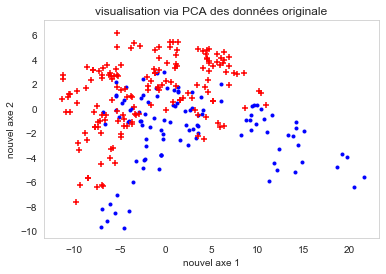

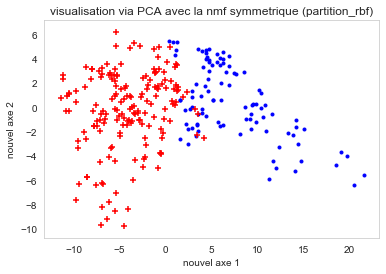

In [29]:
plotcluster(bank_test, bank_test_labels, 'visualisation via PCA des données originale')
plotcluster(bank_test, partition_rbf[0,:], 'visualisation via PCA avec la nmf symmetrique (partition_rbf)')

### Question 4d:
### Application de la SymNMF avec noyeu polynomial

In [30]:
K2_test = matriceGram_Polynomial(bank_test)
H2_sym = SYMNMF(K2_test, 2, iter_max=400)
partition_poly = showclusters(H2_sym.T)

### Indices internes et externes

In [31]:
purity_poly  = purity (bank_test_labels,partition_poly[1,:])
entropy_poly = entropy(bank_test_labels,partition_poly[1,:])

DB_poly   = davies_bouldin(K2_test,partition_poly[1,:])
Dunn_poly = dunn(K2_test,partition_poly[1,:])
CH_poly   = calinski_harabasz(K2_test,partition_poly[1,:])

purity_poly, entropy_poly, DB_poly, Dunn_poly, CH_poly

(0.6617647058823529,
 0.6315051723063931,
 1.1966472839896374,
 0.08480239225252109,
 259199049383040.44)

### Visualisation

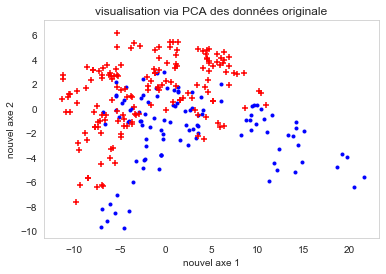

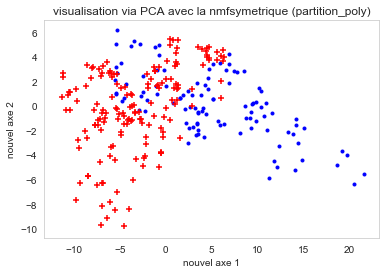

In [32]:
plotcluster(bank_test, bank_test_labels, 'visualisation via PCA des données originale')
plotcluster(bank_test, partition_poly[1,:], 'visualisation via PCA avec la nmfsymetrique (partition_poly)')

## Question 5 : Conclusion

## Remarque par rapport à la visualisation:

Les méthode NMF et semi NMF permet de faire un clustering en séparant lineairement les points (les billets).

L'avantage de la méthode Symmetrique NMF (surtout avec noyau Polynomial) arrive a faire un clustering d'une maniere plus complexes donc donne de meuilleurs résultat que les méthodes NMF Classique.

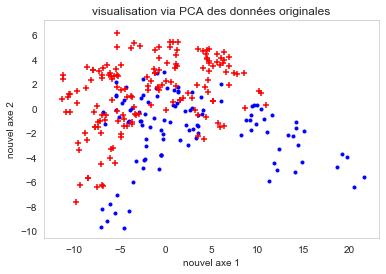

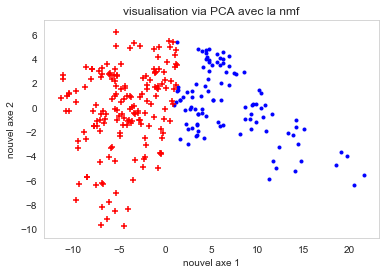

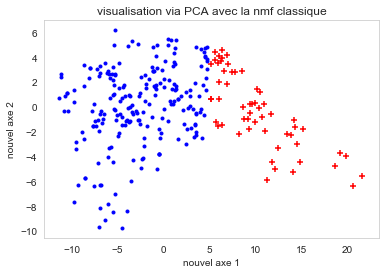

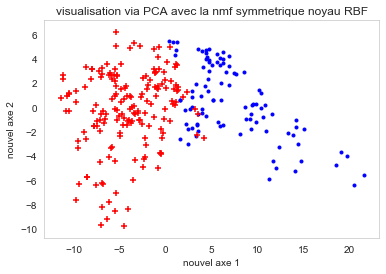

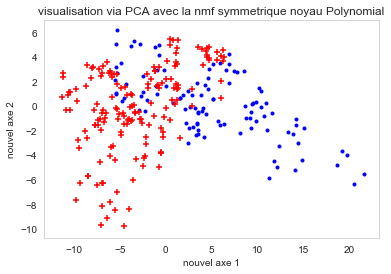

In [33]:
plotcluster(bank_test, bank_test_labels   , 'visualisation via PCA des données originales')
plotcluster(bank_test, partition_test[0,:], 'visualisation via PCA avec la nmf')
plotcluster(bank_test, partition_nmf_test[0,:], 'visualisation via PCA avec la nmf classique')
plotcluster(bank_test, partition_rbf[0,:] , 'visualisation via PCA avec la nmf symmetrique noyau RBF')
plotcluster(bank_test, partition_poly[1,:], 'visualisation via PCA avec la nmf symmetrique noyau Polynomial')

## Remarque par rapport aux indices (de qualité du clustering ) internes et externes :

In [34]:
print('Méthode NMF : \n', purity_NMF , entropy_NMF , DB_NMF , Dunn_NMF , CH_NMF )
print('Méthode SNMF: \n', purity_SNMF, entropy_SNMF, DB_SNMF, Dunn_SNMF, CH_SNMF)
print('Méthode SymNMF RBF  : \n', purity_RBF , entropy_RBF , DB_RBF , Dunn_RBF , CH_RBF )
print('Méthode SymNMF Poly : \n', purity_poly, entropy_poly, DB_poly, Dunn_poly, CH_poly)

Méthode NMF : 
 0.625 0.6599951944467781 0.41084097807864906 0.6599122247844939 3276535.0737899356
Méthode SNMF: 
 0.6102941176470589 0.6578850919057102 0.4623408334156941 0.4785017412023996 4082776.314584705
Méthode SymNMF RBF  : 
 0.5992647058823529 0.663153449959188 2.6235564536588747 0.17082964597833128 55158.3167953502
Méthode SymNMF Poly : 
 0.6617647058823529 0.6315051723063931 1.1966472839896374 0.08480239225252109 259199049383040.44


### Remarques:
* Méthode NMF & SNMF : le résultat est quasi le même (il n'y a pas beaucoup de différence), excepté pour la précision qui est meuilleur avec la SNMF car c'est la méthode adapté a ce type de données (avec des valeurs négatives). L'indice Dunn est meuilleur que dans ces methodes par rapport à la symmetrique NMF

* Méthode SymNMF RBF  :  Dunn est meuilleur que poly par contre posséde le plus bas indice CH (beaucoup trop petit par rapport aux autres méthodes)

* Méthode SymNMF Poly : a le meuilleur indices entropy, purity et CH

### Metriques implémenté dans scikit-learn:
* J'ai remarqué qu'il y a un rapport de deux entre l'indice DB que j'ai implémenter et l'indice DB implémenté dans scikit-learn. Cela est peut être du à la fonction de distance utilisé qui n'est pas forcément la même.

In [35]:
metrics.davies_bouldin_score(bank_test, partition_nmf_test[1,:])/2 , \
metrics.davies_bouldin_score(bank_test, partition_test[1,:])/2 , \
metrics.davies_bouldin_score(K_test, partition_rbf[1,:])/2 , \
metrics.davies_bouldin_score(K2_test, partition_poly[1,:])/2

(0.41084097807864894,
 0.4623408334156942,
 2.6235564536588756,
 1.1966472839896376)

In [36]:
metrics.silhouette_score(bank_test, partition_nmf_test[1,:]), \
metrics.silhouette_score(bank_test, partition_test[1,:]) , \
metrics.silhouette_score(K_test, partition_rbf[1,:]) , \
metrics.silhouette_score(K2_test, partition_poly[1,:])

(0.42324741565008284,
 0.4077633237472291,
 0.02460794389063339,
 0.1333917696657761)

In [37]:
metrics.calinski_harabasz_score(bank_test, partition_nmf_test[1,:]) , \
metrics.calinski_harabasz_score(bank_test, partition_test[1,:]) , \
metrics.calinski_harabasz_score(K_test, partition_rbf[1,:]) , \
metrics.calinski_harabasz_score(K2_test, partition_poly[1,:])

(213.23525581708924, 259.5360267862993, 8.589076363448934, 24.6190686351176)

# References utilisés :

### NMF : Cours et articles : 

* Cours NMF : https://lipn.univ-paris13.fr/~matei/teaching_fichiers/0910/p3slides.pdf
* Wikistat NMF : http://wikistat.fr/pdf/st-m-explo-nmf.pdf
* régles de mises à jours multiplicatives:  https://www.jjburred.com/research/pdf/jjburred_nmf_updates.pdf
* scikit-learn NMF : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
* conférence Younès BENNANI et Ievgen REDKO: https://epat2014.sciencesconf.org/conference/epat2014/pages/EPAT_NMF_reduced_1.pdf
* Certaines notions importantes: https://lipn.univ-paris13.fr/~matei/teaching_fichiers/0910/AppStat/AS6.pdf

### Bibliotèque NMF : 
* Choix de la librairie pyMF3: https://towardsdatascience.com/overview-of-matrix-factorisation-techniques-using-python-8e3d118a9b39

### Méthodes à Noyaux
* Méthode à Noyau : https://fr.wikipedia.org/wiki/Astuce_du_noyau
* Matrice de Gram : https://fr.wikipedia.org/wiki/D%C3%A9terminant_de_Gram
* Noyau polynomial : https://fr.wikipedia.org/wiki/Noyau_polynomial

### indices de qualités clustering 
* Matrice de contingence : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cluster.contingency_matrix.html
* Pureté : https://stackoverflow.com/questions/34047540/python-clustering-purity-metric 
* entropie : https://stats.stackexchange.com/questions/338719/calculating-clusters-entropy-python
* entropie de shannon :  https://fr.wikipedia.org/wiki/Entropie_de_Shannon
* DB   : https://fr.wikipedia.org/wiki/Indice_de_Davies-Bouldin
* Dunn : https://fr.wikipedia.org/wiki/Indice_de_Dunn
* CH   : https://fr.wikipedia.org/wiki/Indice_de_Calinski-Harabasz